## Ensemble Probability with Python ##
**by Tyler Wixtrom**<br>
*2018 Unidata Users Workshop*

In this example, we will compute and plot ensemble probability for simulated reflectivity greater than 25 dBz.


In [1]:
import numpy as np
from netCDF4 import Dataset, num2date
import operator

We will start by reading in the simulated reflectivity data from each ensemble member with the netCDF4-python package and storing the data in a dictionary.

In [2]:
refl = {}
for i in range(1, 21):
    data = Dataset('2015020112/wrfprst_d01_2015020112_mem'+str(i)+'.nc')
    refl['mem'+str(i)] = data.variables['DBZ'][:].data

In [3]:
lat = data.variables['lat'][0, :]
lon = data.variables['lon'][0, :]
vtimes = num2date(data.variables['valid_time'][:], data.variables['valid_time'].units)

### Ensemble Probability ###
Ensemble probability is a relatively simple calculation and can be acomplished quite easily in python. The probability is simply defined as the number of members meeting a pre-defined criteria (for this example simulated reflectivity greater than 25 dBz) divided by the total number of members. 

In [4]:
def ens_prob(thresh, operator, *args):
    """Computes the ensemble probability"""
    thresh_arg_data = []
    for arg in args:
        data = np.zeros_like(arg)
        data[operator(arg, thresh)] = 1.
        thresh_arg_data.append(data)
    thresh_data = np.stack(thresh_arg_data, axis=0)
    return np.mean(thresh_data, axis=0)

In [5]:
points = ens_prob(25., operator.gt, *[refl[key] for key in refl.keys()])

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Set up our projection
plotcrs = ccrs.AlbersEqualArea(central_longitude=-100.0, central_latitude=45.0)

# Get data to plot state and province boundaries
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lakes',
    scale='50m',
    facecolor='none')

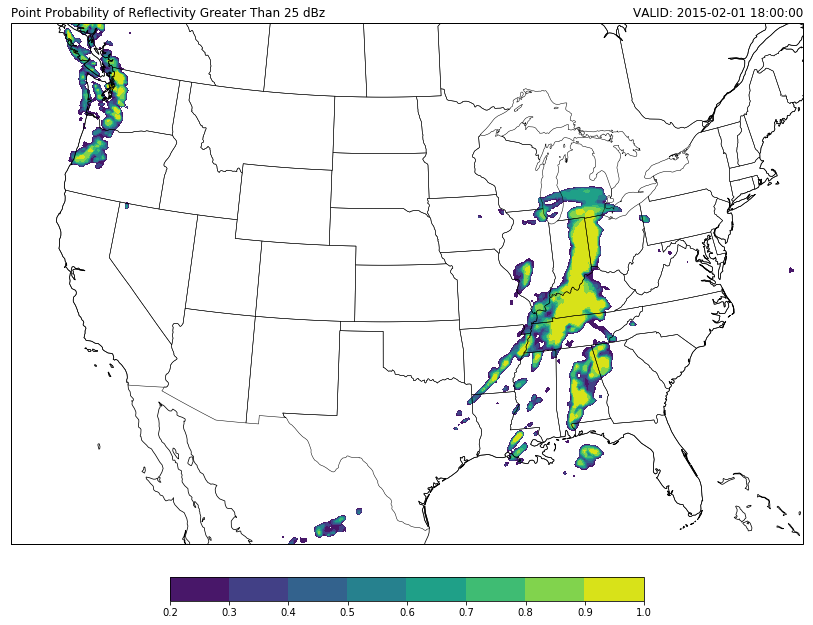

In [7]:
# Choose a time to plot
time = 2

# Set up the figure and add a map background
fig = plt.figure(1, figsize=(17., 12.))
ax = plt.subplot(111, projection=plotcrs)
ax.set_extent((-123, -74, 25, 51), ccrs.PlateCarree())
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(states_provinces, edgecolor='black', linewidth=0.5)

# Plot the surface
contours = np.arange(0.2, 1.1, 0.1)
cf = ax.contourf(lon, lat, points[time,], contours, transform=ccrs.PlateCarree())
plt.colorbar(cf, orientation='horizontal', shrink=0.5, pad=0.05)
# Make some titles
plt.title('Point Probability of Reflectivity Greater Than 25 dBz', loc='left')
plt.title('VALID: %s' % (vtimes[time]), loc='right')
plt.show()

In [8]:
from scipy.ndimage import gaussian_filter
gprobs = gaussian_filter(points, 1)

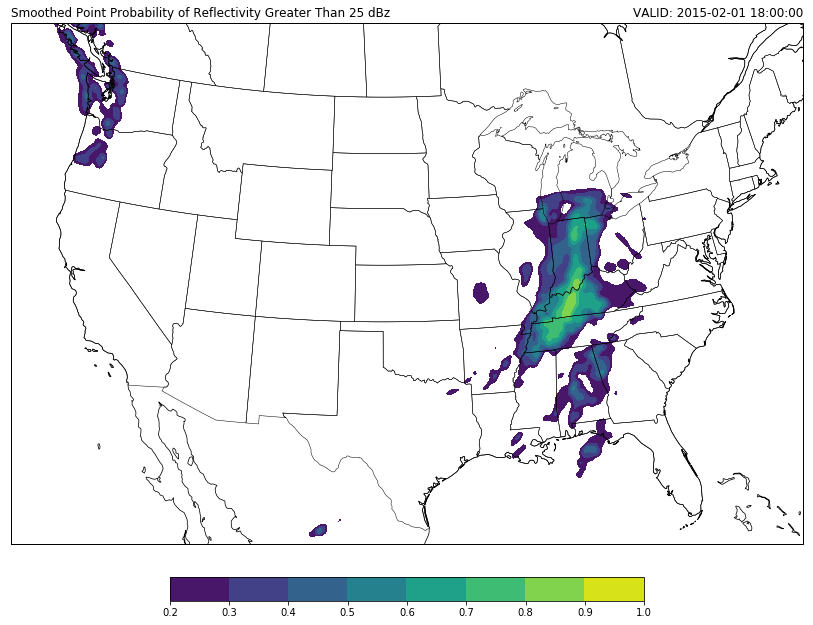

In [9]:
# Choose a time to plot
time = 2

# Set up the figure and add a map background
fig = plt.figure(1, figsize=(17., 12.))
ax = plt.subplot(111, projection=plotcrs)
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent((-123, -74, 25, 51), ccrs.PlateCarree())
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(states_provinces, edgecolor='black', linewidth=0.5)

# Plot the probabilities
contours = np.arange(0.2, 1.1, 0.1)
cf = ax.contourf(lon, lat, gprobs[time, ], contours, transform=ccrs.PlateCarree())
plt.colorbar(cf, orientation='horizontal', shrink=0.5, pad=0.05)

# Make some titles
plt.title('Smoothed Point Probability of Reflectivity Greater Than 25 dBz', loc='left')
plt.title('VALID: %s' % (vtimes[time]), loc='right')
plt.show()

In [10]:
from numba import njit

@njit
def distance_mask(x, y, x1, y1, r, xshape, yshape):
    """Compute mask of points within the specified radius"""
    num = 0
    xi = []
    yi = []
    for i in range(xshape):
        for j in range(yshape):
            d = ((x[i, j] - x1)**2 + (y[i, j] - y1)**2)**0.5
            if d <= r:
                xi.append(i)
                yi.append(j)
                num += 1.
    return xi, yi, num


@njit
def neighborhood_prob(points, r, x, y):
    """Computes ensemble neighborhood probability"""
    neighbor_probs = np.full_like(points, np.nan)
    tshape, xshape, yshape = points.shape
    for i in range(xshape):
        for j in range(yshape):
            xi, yi, num = distance_mask(x, y, x[i, j], y[i, j], r, xshape, yshape)
            for k in range(tshape):
                point_sum = 0
                for a in range(len(xi)):
                    point_sum += points[k, xi[a], yi[a]]
                neighbor_probs[k, i, j] = point_sum / num
    return neighbor_probs

In [11]:
crs = ccrs.AlbersEqualArea(central_longitude=-100.0, central_latitude=45.0)
tlatlons = crs.transform_points(ccrs.PlateCarree(), lon, lat)
tlons = tlatlons[:, :, 0]
tlats = tlatlons[:, :, 1]

In [12]:
nprobs = neighborhood_prob(points, 40000, tlons, tlats)

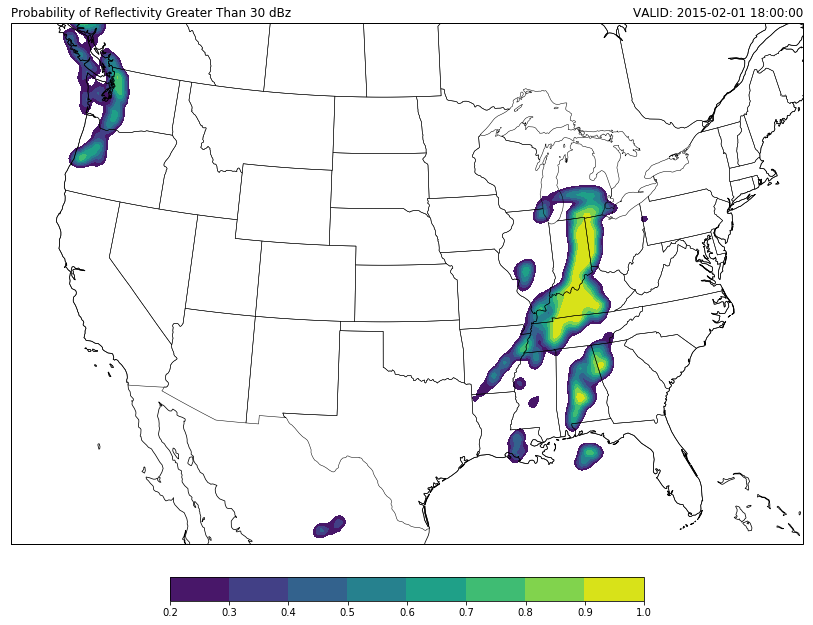

In [13]:
# Choose a time to plot
time = 2

fig = plt.figure(1, figsize=(17., 12.))
ax = plt.subplot(111, projection=plotcrs)
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent((-123, -74, 25, 51), ccrs.PlateCarree())
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(states_provinces, edgecolor='black', linewidth=0.5)

# Plot the surface
contours = np.arange(0.2, 1.1, 0.1)
cf = ax.contourf(lon, lat, nprobs[time, ],
                 contours, transform=ccrs.PlateCarree())
plt.colorbar(cf, orientation='horizontal', shrink=0.5, pad=0.05)
# Make some titles
plt.title('Probability of Reflectivity Greater Than 30 dBz', loc='left')
plt.title('VALID: %s' % (vtimes[time]), loc='right')
plt.show()